# Comparing Algorithms: A* vs Dijkstra on the City's Map

In [1]:
import osmnx as ox
import random
import heapq
import sys
sys.setrecursionlimit(100000)

### Importing and cleaning the map

In [2]:
place_name = "Ciudad de México, México"
G = ox.graph_from_place(place_name, network_type="drive")

In [3]:
for edge in G.edges:
    # Cleaning the "maxspeed" attribute, some values are lists, some are strings, some are None
    maxspeed = 40
    if "maxspeed" in G.edges[edge]:
        maxspeed = G.edges[edge]["maxspeed"]
        if type(maxspeed) == list:
            speeds = [ int(speed) for speed in maxspeed ]
            maxspeed = min(speeds)
        elif type(maxspeed) == str:
            maxspeed = int(maxspeed)
    G.edges[edge]["maxspeed"] = maxspeed
    # Adding the "weight" attribute (time = distance / speed)
    G.edges[edge]["weight"] = G.edges[edge]["length"] / maxspeed

### Visual utils

In [4]:
def style_unvisited_edge(edge):        
    G.edges[edge]["color"] = "#d36206"
    G.edges[edge]["alpha"] = 0.2
    G.edges[edge]["linewidth"] = 0.5

def style_visited_edge(edge):
    G.edges[edge]["color"] = "#d36206"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_active_edge(edge):
    G.edges[edge]["color"] = '#e8a900'
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_path_edge(edge):
    G.edges[edge]["color"] = "white"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

In [5]:
def plot_graph():
    ox.plot_graph(
        G,
        node_size =  [ G.nodes[node]["size"] for node in G.nodes ],
        edge_color = [ G.edges[edge]["color"] for edge in G.edges ],
        edge_alpha = [ G.edges[edge]["alpha"] for edge in G.edges ],
        edge_linewidth = [ G.edges[edge]["linewidth"] for edge in G.edges ],
        node_color = "white",
        bgcolor = "#18080e"
    )

In [6]:
def plot_heatmap(algorithm):
    edge_colors = ox.plot.get_edge_colors_by_attr(G, f"{algorithm}_uses", cmap="hot")
    fig, _ = ox.plot_graph(
        G,
        node_size = 0,
        edge_color = edge_colors,
        bgcolor = "#18080e"
    )

## Algorithms implementation

In [7]:
def dijkstra(orig, dest, plot=False):
    for node in G.nodes:
        G.nodes[node]["visited"] = False
        G.nodes[node]["distance"] = float("inf")
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
    for edge in G.edges:
        style_unvisited_edge(edge)
    G.nodes[orig]["distance"] = 0
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    pq = [(0, orig)]
    step = 0
    while pq:
        _, node = heapq.heappop(pq)
        if node == dest:
            if plot:
                print("Iteraciones:", step)
                plot_graph()
            return
        if G.nodes[node]["visited"]: continue
        G.nodes[node]["visited"] = True
        for edge in G.out_edges(node):
            style_visited_edge((edge[0], edge[1], 0))
            neighbor = edge[1]
            weight = G.edges[(edge[0], edge[1], 0)]["weight"]
            if G.nodes[neighbor]["distance"] > G.nodes[node]["distance"] + weight:
                G.nodes[neighbor]["distance"] = G.nodes[node]["distance"] + weight
                G.nodes[neighbor]["previous"] = node
                heapq.heappush(pq, (G.nodes[neighbor]["distance"], neighbor))
                for edge2 in G.out_edges(neighbor):
                    style_active_edge((edge2[0], edge2[1], 0))
        step += 1

In [8]:
def depth_first_limited_search(orig, dest, limit, plot=False):
    # Initialize all nodes: set visited to False, reset styles, and depth to None
    for node in G.nodes:
        G.nodes[node]["visited"] = False
        G.nodes[node]["previous"] = None
        G.nodes[node]["depth"] = None
        G.nodes[node]["size"] = 0
    for edge in G.edges:
        style_unvisited_edge(edge)
    
    # Set origin and destination sizes for visualization
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    G.nodes[orig]["depth"] = 0

    # Helper function for recursive DLS
    def dls_visit(node, depth):
        if node == dest or depth > limit:
            return node == dest
        G.nodes[node]["visited"] = True
        for neighbor in G.neighbors(node):
            if not G.nodes[neighbor]["visited"]:
                G.nodes[neighbor]["previous"] = node
                G.nodes[neighbor]["depth"] = depth + 1
                # Style the edge as active or visited
                style_visited_edge((node, neighbor, 0))
                found = dls_visit(neighbor, depth + 1)
                if found:
                    return True
                # Optionally, reset style if backtracking (for clearer visualization)
                # style_unvisited_edge((node, neighbor, 0))
        return False

    # Start the DLS from the origin
    found = dls_visit(orig, 0)

    if plot:
        if found:
            print(f"Destination {dest} found within depth limit {limit}.")
        else:
            print(f"Destination {dest} not found within depth limit {limit}.")
        plot_graph()

In [9]:
import queue

def breadth_first_search(orig, dest, plot=False):
    # Initialize all nodes: set visited to False, distance to infinity, and reset styles
    for node in G.nodes:
        G.nodes[node]["visited"] = False
        G.nodes[node]["distance"] = float("inf")
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
    for edge in G.edges:
        style_unvisited_edge(edge)

    # Set origin node properties
    G.nodes[orig]["distance"] = 0
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50

    # Create a queue for BFS
    q = queue.Queue()
    q.put(orig)

    step = 0  # To count the iterations

    while not q.empty():
        node = q.get()

        if node == dest:
            if plot:
                print("Iterations:", step)
                plot_graph()
            break

        if G.nodes[node]["visited"]:
            continue

        G.nodes[node]["visited"] = True

        for neighbor in G.neighbors(node):
            if not G.nodes[neighbor]["visited"]:
                G.nodes[neighbor]["previous"] = node
                G.nodes[neighbor]["distance"] = G.nodes[node]["distance"] + 1
                q.put(neighbor)
                # Style the edge as active or visited
                style_visited_edge((node, neighbor, 0))
                for edge in G.out_edges(neighbor):
                    style_active_edge((edge[0], edge[1], 0))

        step += 1

In [10]:
def reconstruct_path(orig, dest, plot=False, algorithm=None):
    for edge in G.edges:
        style_unvisited_edge(edge)
    dist = 0
    speeds = []
    curr = dest
    while curr != orig:
        prev = G.nodes[curr]["previous"]
        dist += G.edges[(prev, curr, 0)]["length"]
        speeds.append(G.edges[(prev, curr, 0)]["maxspeed"])
        style_path_edge((prev, curr, 0))
        if algorithm:
            G.edges[(prev, curr, 0)][f"{algorithm}_uses"] = G.edges[(prev, curr, 0)].get(f"{algorithm}_uses", 0) + 1
        curr = prev
    dist /= 1000
    if plot:
        print(f"Distance: {dist}")
        print(f"Avg. speed: {sum(speeds)/len(speeds)}")
        print(f"Total time: {dist/(sum(speeds)/len(speeds)) * 60}")
        plot_graph()

## Experiment 1

In [11]:
start = random.choice(list(G.nodes))
end = random.choice(list(G.nodes))

Iteraciones: 27642


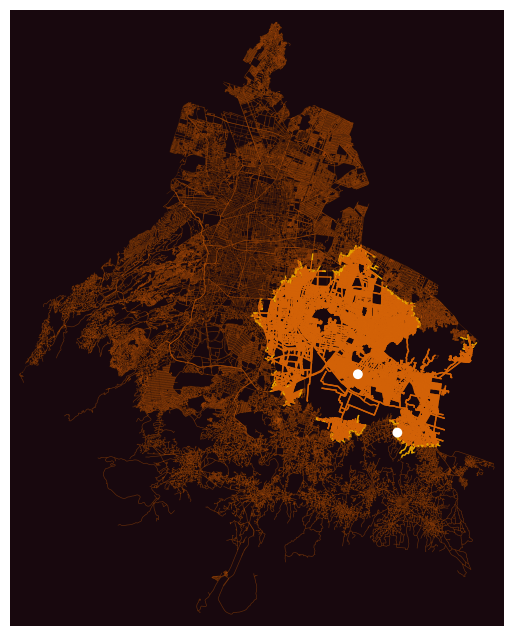

In [12]:
dijkstra(start, end, plot=True)

Distance: 12.468008999999997
Avg. speed: 57.751479289940825
Total time: 12.953443776639341


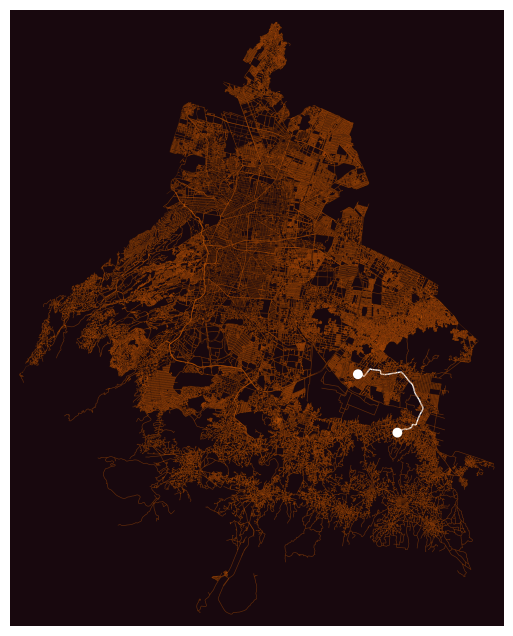

In [13]:
reconstruct_path(start, end, plot=True)

In [14]:
depth_first_limited_search(start, end, 100000, plot=True)

: 

In [ ]:
reconstruct_path(start, end, plot=True)

KeyError: None

In [ ]:
breadth_first_search(start, end, plot=True)

Iterations: 81753


Distance: 28.16090500000001
Avg. speed: 52.51655629139073
Total time: 32.17374518284995


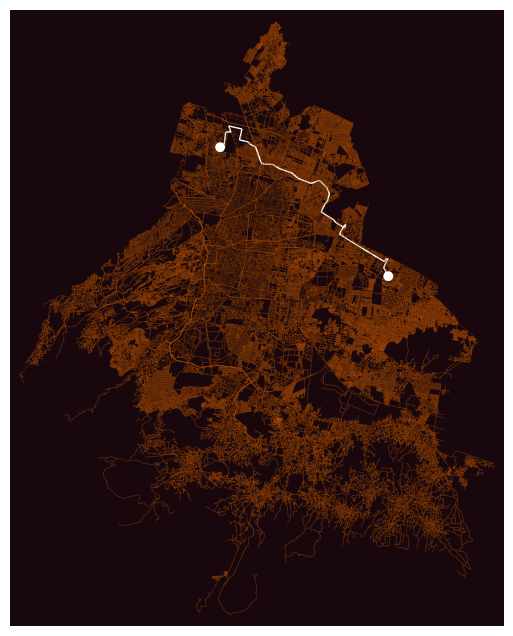

In [ ]:
reconstruct_path(start, end, plot=True)

## Experiment 2

In [ ]:
N = 100 # times to run each algorithm
for edge in G.edges:
    G.edges[edge]["dijkstra_uses"] = 0
    G.edges[edge]["breadth_first_search_uses"] = 0

In [ ]:
for _ in range(N): # (might take a while, depending on N)
    start = random.choice(list(G.nodes))
    end = random.choice(list(G.nodes))
    dijkstra(start, end)
    reconstruct_path(start, end, algorithm="dijkstra")
    breadth_first_search(start, end)
    reconstruct_path(start, end, algorithm="breadth_first_search")

KeyboardInterrupt: 

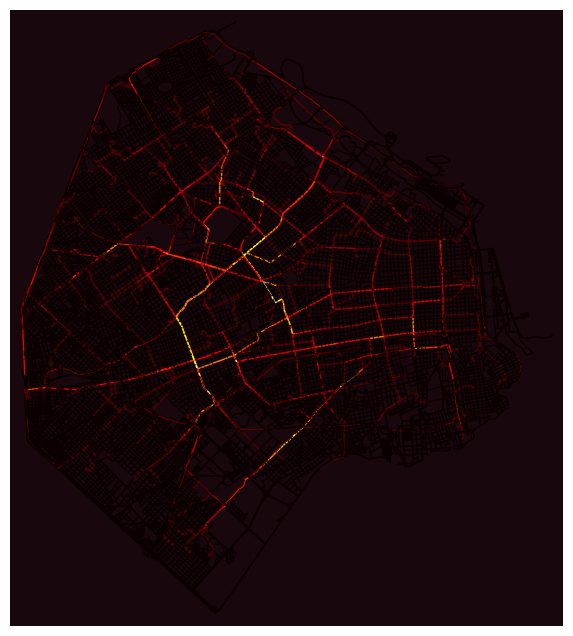

In [ ]:
plot_heatmap("dijkstra")

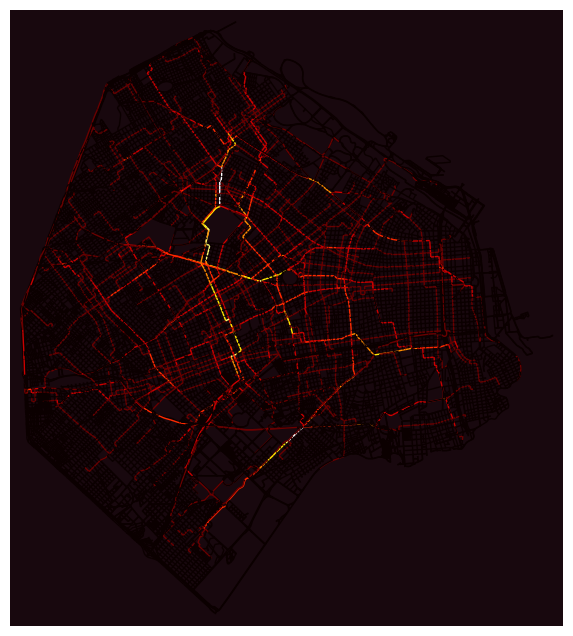

In [ ]:
plot_heatmap("breadth_first_search")